<a href="https://colab.research.google.com/github/Engineer1999/Dual-CNN-Autoencoder-based-lossy-image-encoding-and-decoding/blob/main/Final_128_512_SRAE_4x_PSNR_SSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import distutils
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Conv2DTranspose, UpSampling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 train=tfds.load('clic', split='train', shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/clic/1.0.0.incompleteU5TWOI/clic-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/clic/1.0.0.incompleteU5TWOI/clic-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/clic/1.0.0.incompleteU5TWOI/clic-test.tfrecord


Dataset clic downloaded and prepared to /root/tensorflow_datasets/clic/1.0.0. Subsequent calls will reuse this data.


In [ ]:
test=tfds.load('clic', split='test', shuffle_files=True)

In [ ]:
validate=tfds.load('clic', split='validation', shuffle_files=True)

In [ ]:
print(train)
print(test)
print(validate)

<_OptionsDataset shapes: {image: (None, None, 3)}, types: {image: tf.uint8}>
<_OptionsDataset shapes: {image: (None, None, 3)}, types: {image: tf.uint8}>
<_OptionsDataset shapes: {image: (None, None, 3)}, types: {image: tf.uint8}>


#Resize data to 128x128x3

In [ ]:
train_temp = train.take(10000)

In [ ]:
train_data = []
train_data_sr = []
for example in train_temp:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  temp = np.array(example["image"])
  PIL_image = Image.fromarray(np.uint8(temp)).convert('RGB')
  im_trans = PIL_image.resize((128, 128))
  train_data.append(np.array(im_trans))
  #im_trans = PIL_image.resize((512, 512))
  #train_data_sr.append(np.array(im_trans))


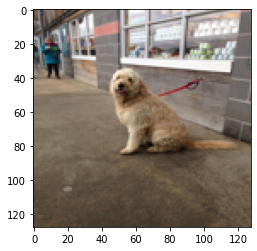

In [ ]:
plt.imshow(train_data[0])

In [ ]:
test_temp = test.take(1000)

In [ ]:
test_data = []
test_data_sr = []
for example in test_temp:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  temp = np.array(example["image"])
  PIL_image = Image.fromarray(np.uint8(temp)).convert('RGB')
  im_trans = PIL_image.resize((128, 128))
  test_data.append(np.array(im_trans)) 
  #im_trans = PIL_image.resize((512, 512))
  #test_data_sr.append(np.array(im_trans))

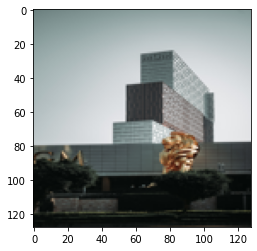

In [ ]:
plt.imshow(test_data[0])

In [ ]:
validate_temp = validate.take(1000)

In [ ]:
validation_data = []
validation_data_sr = []
for example in validate_temp:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  temp = np.array(example["image"])
  PIL_image = Image.fromarray(np.uint8(temp)).convert('RGB')
  im_trans = PIL_image.resize((128, 128))
  validation_data.append(np.array(im_trans))
  #im_trans = PIL_image.resize((512, 512))
  #validation_data_sr.append(np.array(im_trans))

In [ ]:
#train_data_arr = np.zeros((1633, 128, 128, 3), dtype=np.float32)
#test_data_arr = np.zeros((428, 128, 128, 3), dtype=np.float32)
validation_data_arr = np.zeros((102, 128, 128, 3), dtype=np.float32)

#train_data_sr_arr = np.zeros((1633, 512, 512, 3), dtype=np.float32)
#test_data_sr_arr = np.zeros((428, 512, 512, 3), dtype=np.float32)
#validation_data_sr_arr = np.zeros((102, 512, 512, 3), dtype=np.float32)

In [ ]:
#train_data_sr_arr = np.zeros((1633, 512, 512, 3), dtype=np.float32)
#train_data_arr = np.zeros((1633, 128, 128, 3), dtype=np.float32)

In [ ]:
for i in range(1633):
    train_data_arr[i] = train_data[i]/255.0
    #train_data_sr_arr[i] = train_data_sr[i]/255.0
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [ ]:
for i in range(428):
    test_data_arr[i] = test_data[i]/255.0
    #test_data_sr_arr[i] = test_data_sr[i]/255.0
    if i%100 == 0:
        print(i)

0
100
200
300
400


In [ ]:
for i in range(102):
    validation_data_arr[i] = validation_data[i]/255.0
    #validation_data_sr_arr[i] = validation_data_sr[i]/255.0
    if i%100 == 0:
        print(i)

0
100


In [ ]:
validation_data_sr_arr=0
train_data_sr_arr = 0

In [ ]:
validation_data =[]
test_data = []
train_data=[]
validation_data_sr =[]
test_data_sr = []
train_data_sr=[]

# comp-coder model

In [ ]:
def create_model():
  input_img = Input(shape=(128, 128, 3))

  a1 = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(input_img)
  a2 = tf.keras.layers.BatchNormalization()(a1)
  a3 = tf.keras.layers.Activation('sigmoid') (a2)

  a4 = tf.keras.layers.Conv2D(128, (3,3), strides=2, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a3)
  a5 = tf.keras.layers.BatchNormalization()(a4)
  a6 = tf.keras.layers.Activation('sigmoid')(a5)

  a16 = tf.keras.layers.Conv2D(256, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a6)
  a17 = tf.keras.layers.BatchNormalization()(a16)
  a18 = tf.keras.layers.Activation('sigmoid')(a17)

  a19 = tf.keras.layers.Conv2D(128, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a18)
  a20 = tf.keras.layers.BatchNormalization()(a19)
  a21 = tf.keras.layers.Activation('sigmoid')(a20)

  skip_0 = tf.keras.layers.Add()([a21, a6])

  a22 = tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(skip_0)
  a23 = tf.keras.layers.BatchNormalization()(a22)
  a24 = tf.keras.layers.Activation('sigmoid')(a23)

  a25 = tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a24)
  a26 = tf.keras.layers.BatchNormalization()(a25)
  a27 = tf.keras.layers.Activation('sigmoid')(a26)

#compressed version
  a28 = tf.keras.layers.Conv2D(3, (3,3),strides=1, padding='same')(a27)
  a29 = tf.keras.layers.BatchNormalization()(a28)
  a30 = tf.keras.layers.Activation('sigmoid')(a29)
################

  #Decoder
  a34 = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a30)
  a35 = tf.keras.layers.BatchNormalization()(a34)
  a36 = tf.keras.layers.Activation('sigmoid')(a35)  

  a45 = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a36)
  a46 = tf.keras.layers.BatchNormalization()(a45)
  a47 = tf.keras.layers.Activation('sigmoid')(a46)

  a55 = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a47)
  a56 = tf.keras.layers.BatchNormalization()(a55)
  a57 = tf.keras.layers.Activation('sigmoid')(a56)

  skip_1 = tf.keras.layers.Add()([a47, a57])

  a58 = tf.keras.layers.Conv2DTranspose(3, (3,3), strides=1, padding='same', kernel_regularizer = regularizers.l1(10e-10))(a57)
  a59 = tf.keras.layers.BatchNormalization()(a58)
  a60 = tf.keras.layers.Activation('sigmoid')(a59)

  model = Model(input_img, a60)
  
  return model

In [ ]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 64) 256         conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 64) 0           batch_normalization_19[0][0]     
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ), loss='mae')

In [ ]:
history_comp = model.fit(x=train_data_arr, y=train_data_arr, epochs=150, validation_split=0.2, batch_size=32, validation_data=(validation_data_arr, validation_data_arr))

Epoch 1/150
41/41 [==============================] - 106s 2s/step - loss: 0.1458 - val_loss: 0.3684
Epoch 2/150
41/41 [==============================] - 53s 1s/step - loss: 0.1142 - val_loss: 0.2925
Epoch 3/150
41/41 [==============================] - 53s 1s/step - loss: 0.1057 - val_loss: 0.2618
Epoch 4/150
41/41 [==============================] - 53s 1s/step - loss: 0.0978 - val_loss: 0.2467
Epoch 5/150
41/41 [==============================] - 53s 1s/step - loss: 0.0903 - val_loss: 0.2226
Epoch 6/150
41/41 [==============================] - 53s 1s/step - loss: 0.0792 - val_loss: 0.2204
Epoch 7/150
41/41 [==============================] - 53s 1s/step - loss: 0.0739 - val_loss: 0.2111
Epoch 8/150
41/41 [==============================] - 53s 1s/step - loss: 0.0685 - val_loss: 0.2109
Epoch 9/150
41/41 [==============================] - 53s 1s/step - loss: 0.0645 - val_loss: 0.1985
Epoch 10/150
41/41 [==============================] - 53s 1s/step - loss: 0.0614 - val_loss: 0.2148
Epoch 11

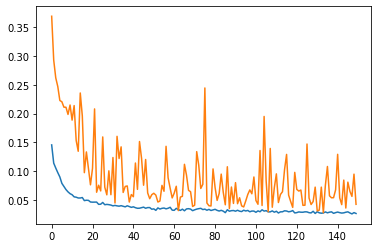

In [ ]:
plt.plot(history_comp.history['loss'])
plt.plot(history_comp.history['val_loss'])

In [ ]:
model.save("/content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_journal_1_good.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.save("/content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_journal_1_good.pb")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_journal_1_good.pb/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_journal_1_good.pb/assets


In [ ]:
comp_model = tf.keras.models.load_model('/content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_journal_1_good.h5')

In [ ]:
 validate_data_comp = comp_model.predict(validation_data_arr)

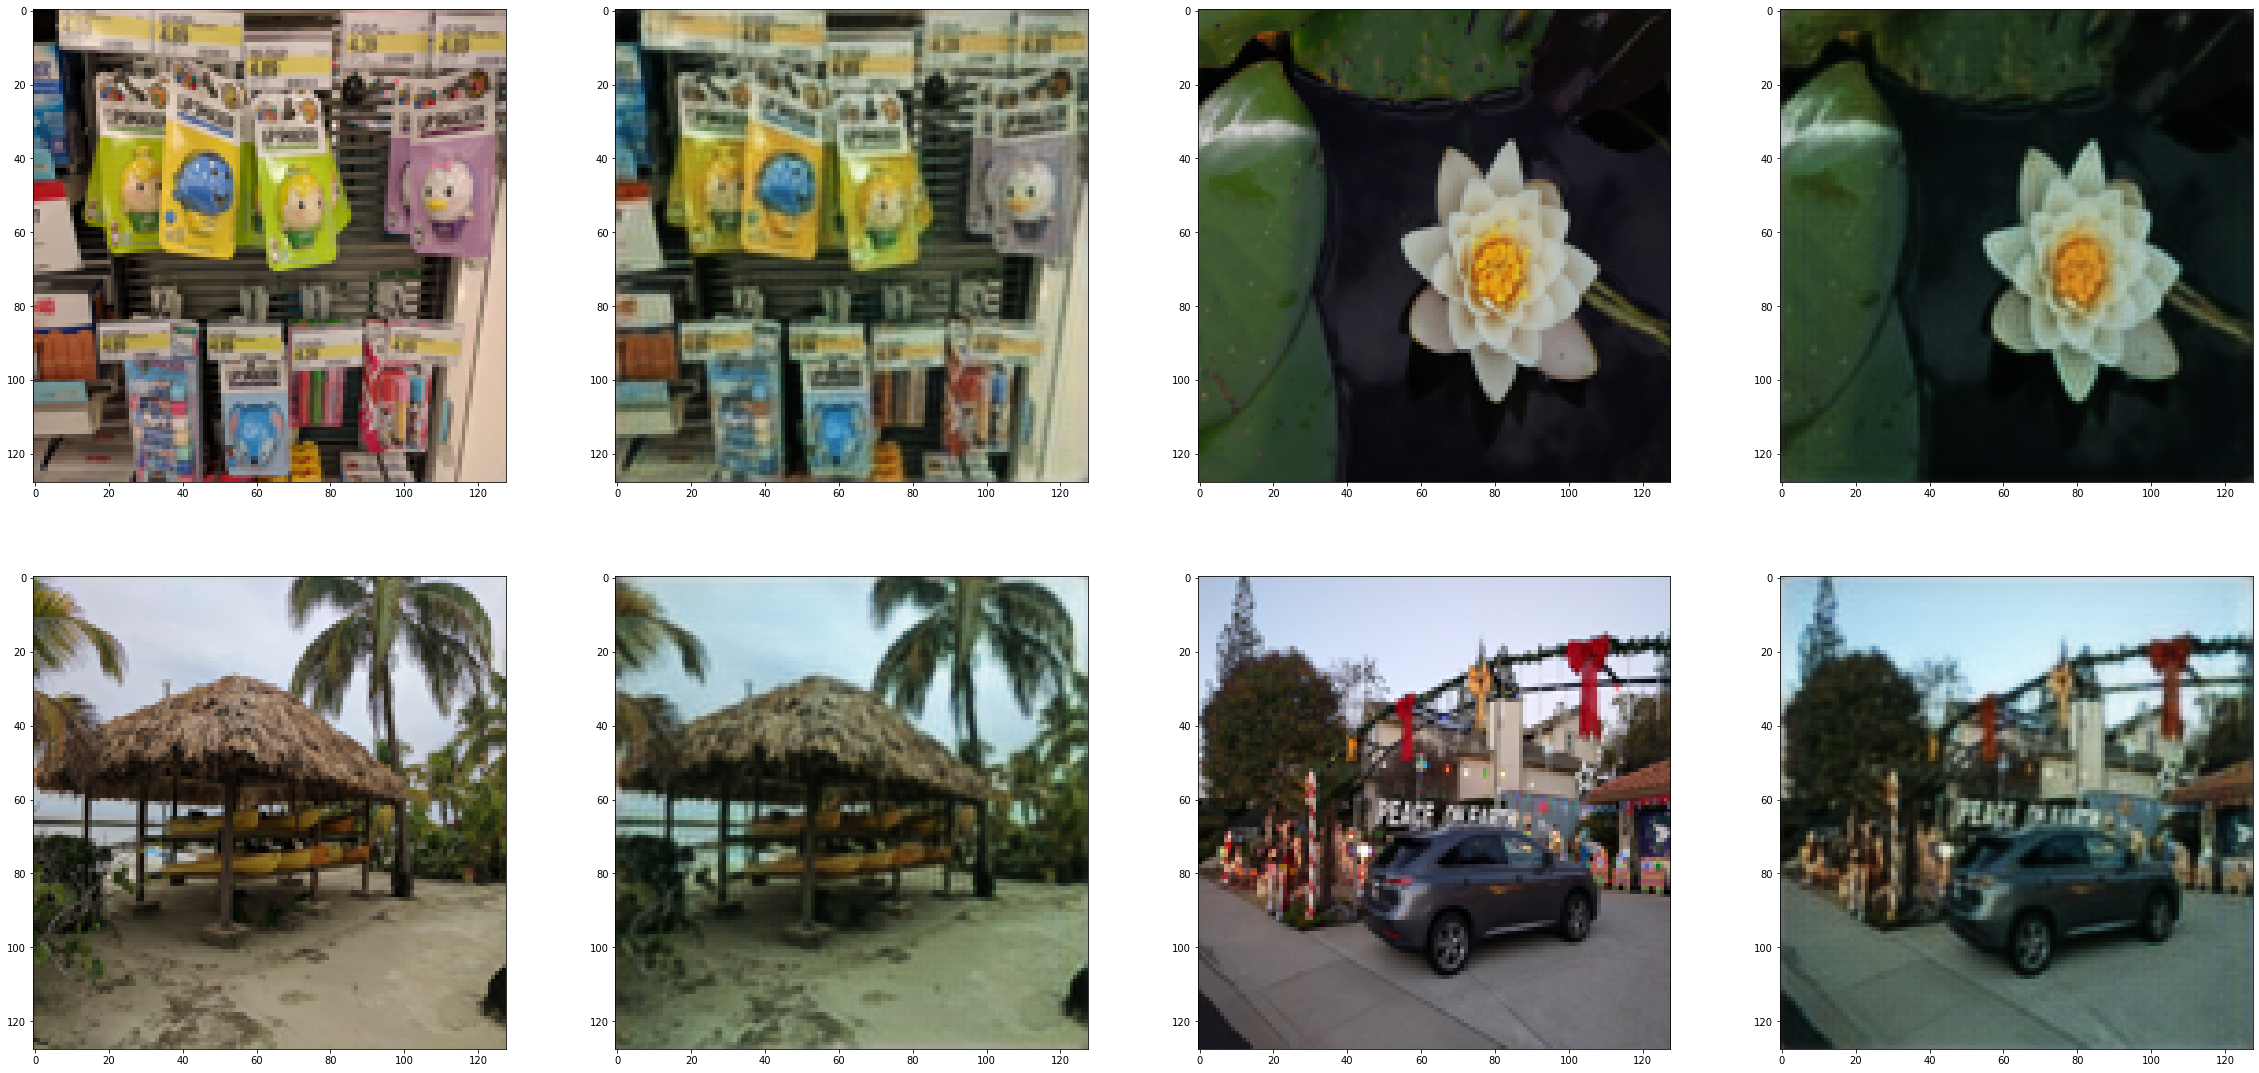

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40,40))
k=10
i=0
for _ in range(4):
  plt.subplot(4,4, i+1)
  plt.imshow(validation_data_arr[k])
  plt.subplot(4,4,i+2)
  plt.imshow(validate_data_comp[k])
  i=i+2
  k=k+1

In [ ]:
validation_data_arr = 0

In [ ]:
#pred_test = comp_model.predict(test_data_arr)

In [ ]:
train_data_comp = comp_model.predict(train_data_arr)

In [ ]:
#train_data_arr = 0

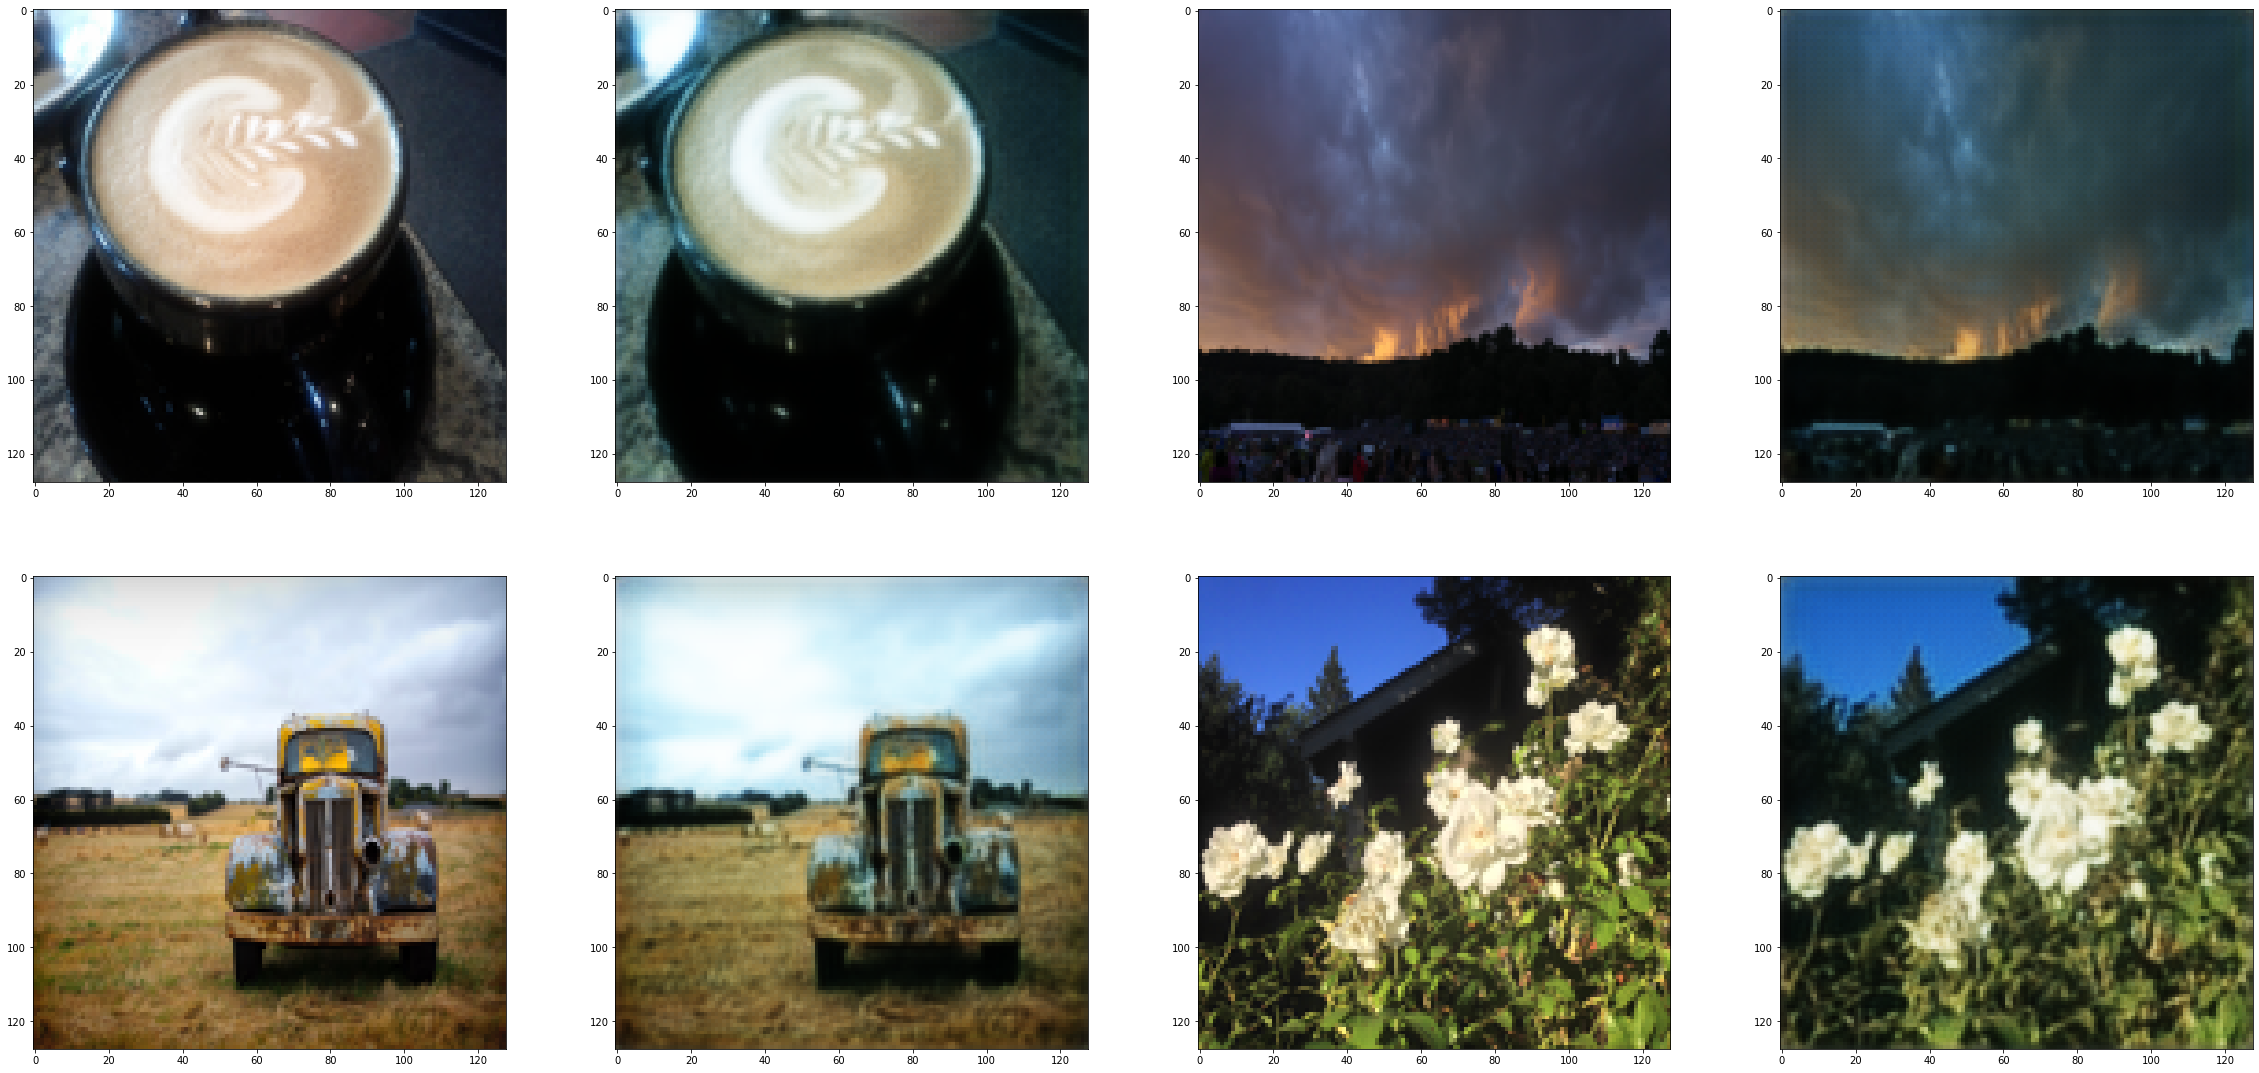

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40,40))
k=10
i=0
for _ in range(4):
  plt.subplot(4,4, i+1)
  plt.imshow(train_data_arr[k])
  plt.subplot(4,4,i+2)
  plt.imshow(train_data_comp[k])
  i=i+2
  k=k+1

# supe-coder model

In [ ]:
def create_SR_model():
    input_img = tf.keras.layers.Input(shape=(128, 128, 3))

    l1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
    l2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
    l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

    l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
    I5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
    l6 = tf.keras.layers.MaxPool2D(padding='same')(I5)    

    e3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

    l8 = tf.keras.layers.UpSampling2D()(e3)
    l9 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
    l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

    l11 = tf.keras.layers.add([l10, I5])

    l12 = tf.keras.layers.UpSampling2D()(l11)
    l13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
    add_e_14 = tf.keras.layers.UpSampling2D()(l13)
    l14 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(add_e_14)
    
    add_e_15 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=2, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l14)
    l15 = tf.keras.layers.add([add_e_15, l2])
    decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

    auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

    return auto_encoder

In [ ]:
sr_model = create_SR_model()

In [ ]:
sr_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 128, 128, 128 3584        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 128 147584      conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 64, 64, 128)  0           conv2d_73[0][0]                  
____________________________________________________________________________________________

In [ ]:
#with strategy.scope():
sr_model = create_SR_model()
sr_model.compile(optimizer='adam', loss='mse')
history_sr = sr_model.fit(train_data_comp, train_data_arr, epochs=100, batch_size=16, validation_data=(validate_data_comp, validation_data_arr))

Epoch 1/100
103/103 [==============================] - 119s 1s/step - loss: 0.2527 - val_loss: 0.2471
Epoch 2/100
103/103 [==============================] - 101s 981ms/step - loss: 0.2442 - val_loss: 0.2469
Epoch 3/100
103/103 [==============================] - 100s 974ms/step - loss: 0.2440 - val_loss: 0.2467
Epoch 4/100
103/103 [==============================] - 100s 973ms/step - loss: 0.2438 - val_loss: 0.2463
Epoch 5/100
103/103 [==============================] - 101s 979ms/step - loss: 0.0750 - val_loss: 0.1365
Epoch 6/100
103/103 [==============================] - 101s 979ms/step - loss: 0.0020 - val_loss: 0.1370
Epoch 7/100
103/103 [==============================] - 101s 979ms/step - loss: 0.0016 - val_loss: 0.1377
Epoch 8/100
103/103 [==============================] - 101s 980ms/step - loss: 0.0015 - val_loss: 0.1372
Epoch 9/100
103/103 [==============================] - 101s 980ms/step - loss: 0.0015 - val_loss: 0.1373
Epoch 10/100
103/103 [==============================] - 10

In [ ]:
sr_model.save('/content/drive/My Drive/Bhargav/Pre-trained/SR_model_4x_journal_SR_IE_good.h5')

In [ ]:
sr_model.save('/content/drive/My Drive/Bhargav/Pre-trained/SR_model_4x_journal_SR_IE_good.pb')

In [ ]:
plt.plot(history_sr.history['loss'])
plt.plot(history_sr.history['val_loss'])
plt.ylim([0, 0.3])

#Pre trained import

In [ ]:
comp_model = tf.keras.models.load_model('/content/drive/My Drive/Bhargav/Pre-trained/comp_model_4x_1_good.h5')
sr_model = tf.keras.models.load_model('/content/drive/My Drive/Bhargav/Pre-trained/SR_model_100_epoch_4xcomp_1_good.h5')

In [ ]:
test_data_comp = model.predict(test_data_arr)

In [ ]:
sr_test_data = sr_model.predict(test_data_comp)

In [ ]:
#sr_pred_train = sr_model.predict(pred_train)

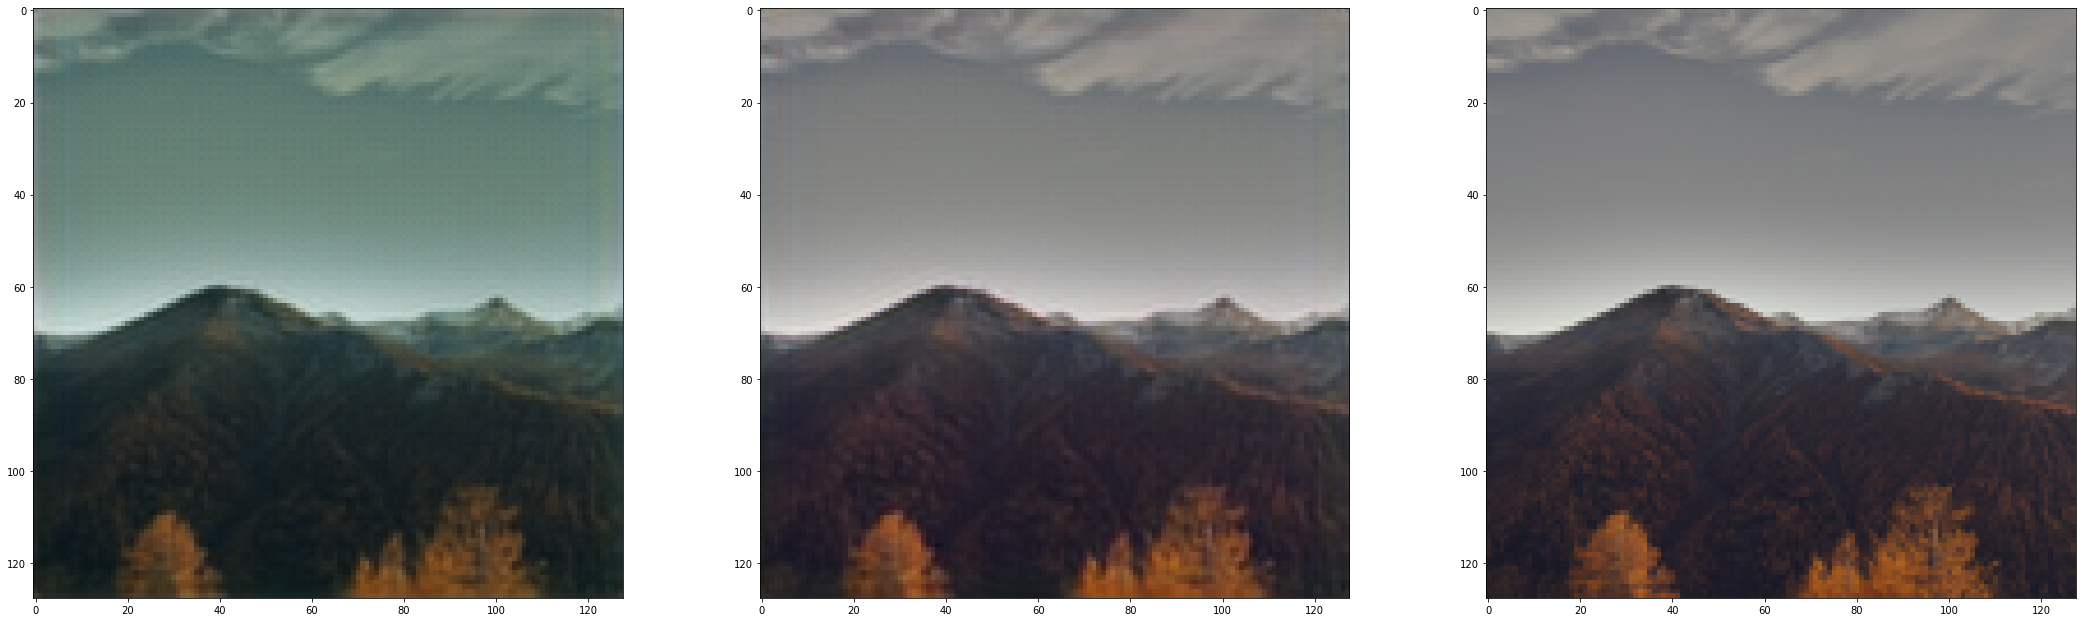

In [ ]:
image_index = 5
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_comp[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_test_data[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_arr[image_index])
plt.show()

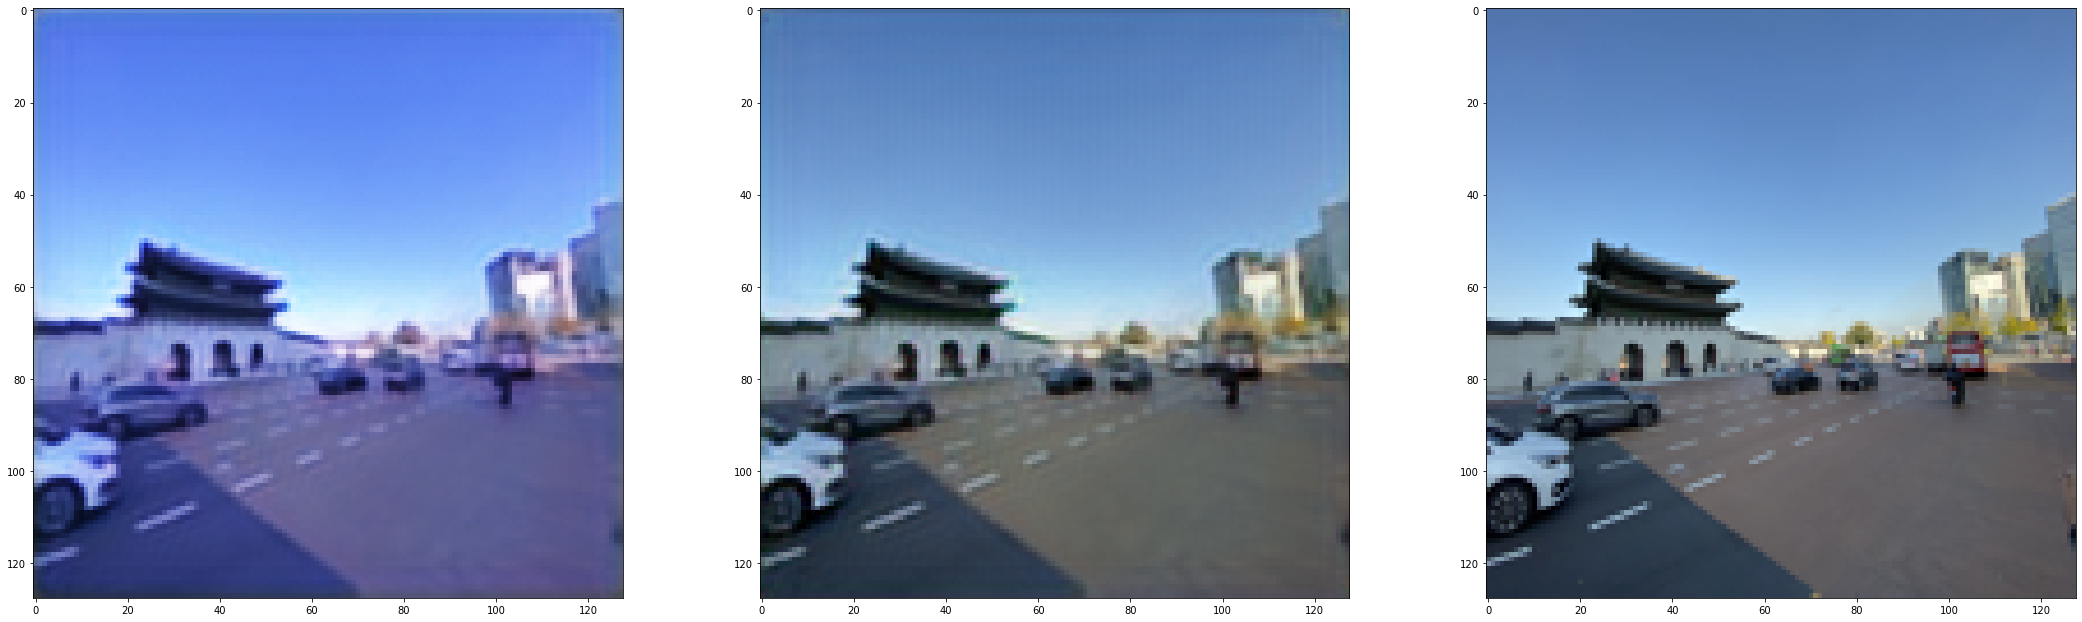

In [ ]:
image_index = 9
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_comp[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_test_data[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_arr[image_index])
plt.show()

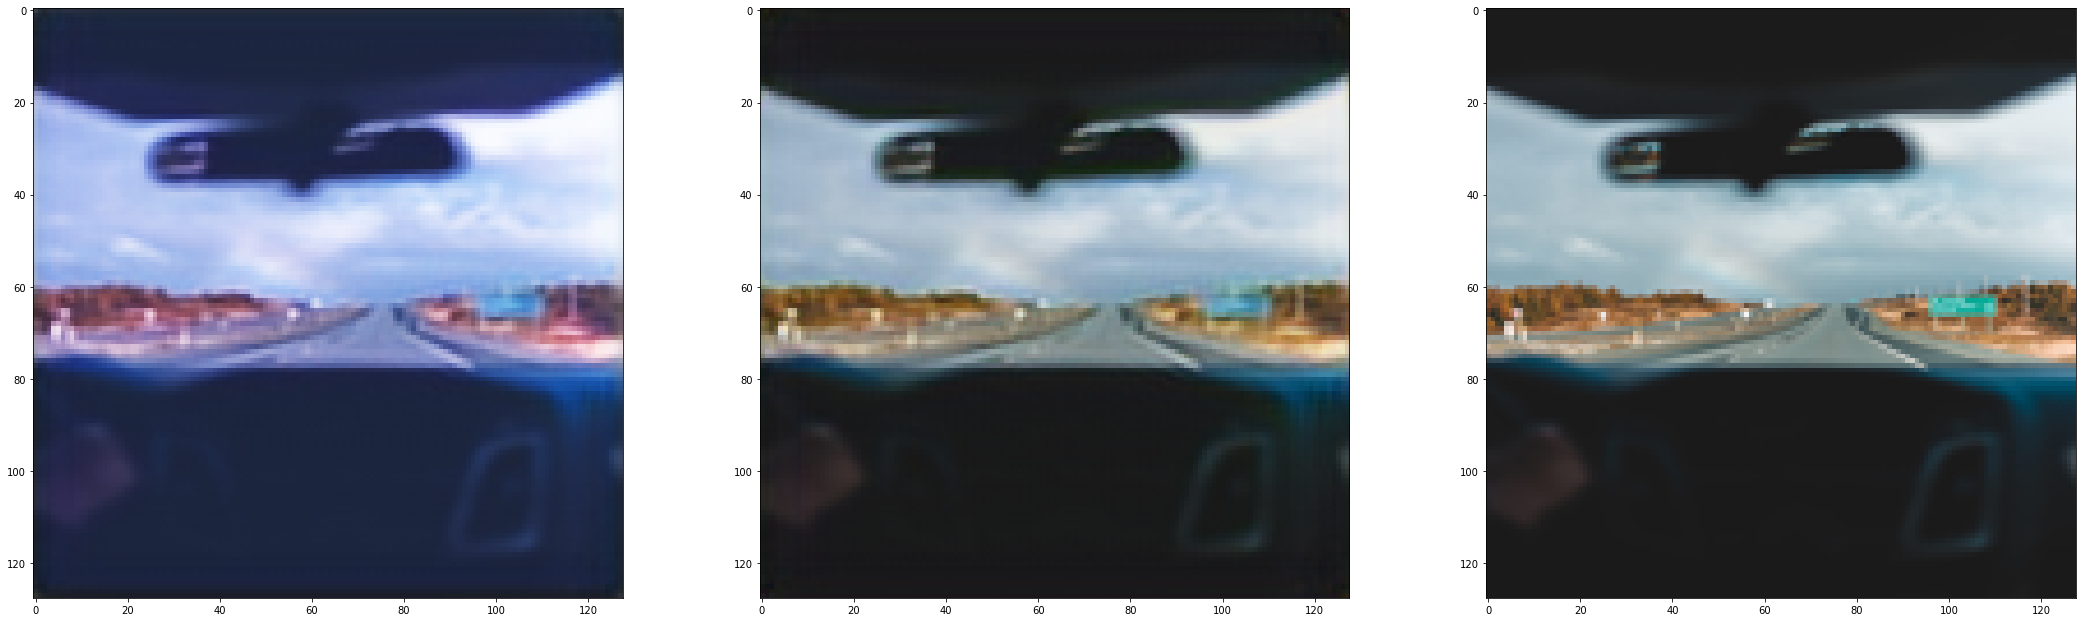

In [ ]:
image_index = 16
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_comp[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_test_data[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(test_data_arr[image_index])
plt.show()

In [ ]:
orig_image = Image.fromarray(np.uint8(test_data_arr[16]*255)).convert('RGB')
comp_image = Image.fromarray(np.uint8(test_data_comp[16]*255)).convert('RGB')
sr_image = Image.fromarray(np.uint8(sr_test_data[16]*255)).convert('RGB')

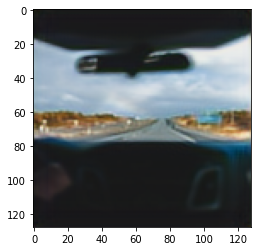

In [ ]:
plt.imshow(sr_image)

In [ ]:
idx = 5

In [ ]:
tf.image.psnr(np.uint8(test_data_arr[idx]*255), np.uint8(test_data_comp[idx]*255), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=19.506285>

In [ ]:
tf.image.psnr(np.uint8(test_data_arr[idx]*255), np.uint8(sr_test_data[idx]*255), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=31.547823>

In [ ]:
tf.image.ssim(np.uint8(test_data_arr[9]*255), np.uint8(test_data_comp[9]*255), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9315626>

In [ ]:
tf.image.ssim(np.uint8(test_data_arr[9]*255), np.uint8(sr_test_data[9]*255), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9632209>

In [ ]:
PIL_image.save('comp_test_3_128.jpg')

In [ ]:
plt.imshow()

In [ ]:
comp_model.evaluate(test_data_arr, test_data_arr)

14/14 [==============================] - 3s 223ms/step - loss: 0.0831


0.08313233405351639

In [ ]:
test_comp = comp_model.predict(test_data_arr)

In [ ]:
sr_model.evaluate(test_comp, test_data_arr)

14/14 [==============================] - 2s 178ms/step - loss: 0.0022


0.0021502673625946045